## CMSC320 Final - Analysis of Life Expectancy Data
### Evan Nadelbach and Joseph Zietowski

# Data Collection

In [38]:
import pandas as pd
import re
from sklearn import linear_model
import numpy as np
from collections import OrderedDict


pd.set_option('display.max_rows', None)

In [2]:
# read in the life expectancy data
# https://apps.who.int/gho/data/view.main.SDG2016LEXv?lang=en
df = pd.read_csv("data/life_expectancy.csv")
df.head()

,Country,Year,Life expectancy at birth (years) (Both sexes),Life expectancy at birth (years) (Male),Life expectancy at birth (years) (Female),Life expectancy at age 60 (years) (Both sexes),Life expectancy at age 60 (years) (Male),Life expectancy at age 60 (years) (Female),Healthy life expectancy (HALE) at birth (years) (Both sexes),Healthy life expectancy (HALE) at birth (years) (Male),Healthy life expectancy (HALE) at birth (years) (Female),Healthy life expectancy (HALE) at age 60 (years) (Both sexes),Healthy life expectancy (HALE) at age 60 (years) (Male),Healthy life expectancy (HALE) at age 60 (years) (Female)
0,Afghanistan,2016,62.7,61.0,64.5,16.3,15.5,17.1,53.0,52.1,54.1,11.3,10.9,11.7
1,Afghanistan,2015,63.2,61.8,64.7,16.3,15.5,17.1,53.2,52.6,54.1,11.2,10.8,11.6
2,Afghanistan,2014,63.0,61.7,64.4,16.2,15.4,17.0,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,2013,62.7,61.5,64.1,16.2,15.4,16.9,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,2012,62.2,60.9,63.6,16.1,15.3,16.8,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# remove the unwanted columns
df = df[["Country", "Year", "Life expectancy at birth (years) (Both sexes)"]]

# rename the columns
df = df.rename(columns={"Life expectancy at birth (years) (Both sexes)": "life_expectancy", \
                        "Country" : "country", "Year" : "year"})

# remove the rows that are not needed (year > 2016)
df.drop(df[df.year >= 2017].index, inplace=True)
len(df)

3111

### Add the BMI data (Age-standardized mean BMI (kg/m^2) 18+ years old)

In [4]:
# read in the data
# https://www.who.int/data/gho/data/indicators/indicator-details/GHO/mean-bmi-(kg-m-)-(age-standardized-estimate)
bmi = pd.read_csv("data/bmi.csv")

# drop the unwanted columns
bmi.drop('Indicator',axis=1,inplace=True)
bmi.drop('Dim2',axis=1,inplace=True)

# drop the unwanted rows
bmi.drop(bmi[bmi.Period < 2000].index, inplace=True)
bmi.drop(bmi[bmi.Dim1 == "Male"].index, inplace=True)
bmi.drop(bmi[bmi.Dim1 == "Female"].index, inplace=True)

# tidy the data in the bmi column
bmi["First Tooltip"].replace(["\[.*\]"], "", inplace=True, regex=True)

# merge the data into our life expectancy dataframe
df = df.merge(bmi, how = "left", left_on = ["country", "year"], right_on = ["Location", "Period"])

# remove more unwanted columns
df.drop('Location', axis=1, inplace=True)
df.drop('Period', axis=1, inplace=True)
df.drop('Dim1', axis=1, inplace=True)

# rename the BMI column
df = df.rename(columns={"First Tooltip": "bmi"})

len(df)

3111

### Add the drinking-water data (% of population using at least basic drinking-water services)

In [5]:
import matplotlib.pyplot as plt

# read in the data
# https://www.who.int/data/gho/data/indicators/indicator-details/GHO/population-using-safely-managed-drinking-water-services-(-)
drinking_water = pd.read_csv("data/drinking_water.csv")

# drop unwanted rows
indicator = "Population using at least basic drinking-water services (%)"
drinking_water.drop(drinking_water[drinking_water.Indicator != indicator].index, inplace=True)

# drop unwanted columns
drinking_water.drop("Indicator", axis=1, inplace=True)

# merge the data into our life expectancy dataframe
df = df.merge(drinking_water, how = "left", left_on = ["country", "year"], right_on = ["Location", "Period"])

# remove more unwanted columns
df.drop('Location', axis=1, inplace=True)
df.drop('Period', axis=1, inplace=True)

# rename the drinking-water column
df = df.rename(columns={"First Tooltip": "drinking_water"})

len(df)

3111

### Add the government expenditure data (% of government expenditure on general health)

In [6]:
# read in the data
# https://www.who.int/data/gho/data/indicators/indicator-details/GHO/general-government-expenditure-on-health-as-a-percentage-of-total-government-expenditure
government_expenditure = pd.read_csv("data/government_expenditure.csv")

# drop unwanted columns
government_expenditure.drop("Indicator", axis=1, inplace=True)

# This loop will iterate for each country in the dataset
for i in government_expenditure['Location'].unique():
    
    # Get only the data for the current country.
    currdata = government_expenditure.loc[government_expenditure['Location'] == i]

    # Linear regression will have the Year (Period) as the predictors and the expenditure (First Tooltip) as the value
    X = currdata[['Period']]
    y = currdata['First Tooltip']

    # Creating and plotting the linear regression line
    reg = linear_model.LinearRegression()
    reg.fit(X, y)

    # Generate data for countries that are missing it for years 2000-2016
    for k in range(2000, 2017):
        if not k in currdata['Period'].values:
            government_expenditure = government_expenditure.append({'Location': i, \
                                                                    'Period': k, \
                                                                    'First Tooltip': round(reg.predict([[k]])[0], 2)}, \
                                                                   ignore_index=True)

# merge the data into our life expectancy dataframe
df = df.merge(government_expenditure, how = "left", left_on = ["country", "year"], right_on = ["Location", "Period"])

# remove more unwanted columns
df.drop('Location', axis=1, inplace=True)
df.drop('Period', axis=1, inplace=True)

# rename the government expenditure column
df = df.rename(columns={"First Tooltip": "government_expenditure"})

len(df)

3111

### Add the HIV data (New HIV infections per 1000 uninfected population)

In [7]:
# read in the data
# https://www.who.int/data/gho/data/indicators/indicator-details/GHO/new-hiv-infections-(per-1000-uninfected-population)
HIV = pd.read_csv("data/HIV.csv")

# drop unwanted rows
HIV.drop(HIV[HIV.Dim1 != "Both sexes"].index, inplace=True)

# drop unwanted columns
HIV.drop("Indicator", axis=1, inplace=True)
HIV.drop("Dim1", axis=1, inplace=True)

# tidy the data in the HIV column
HIV["First Tooltip"].replace(["\[.*\]"], "", inplace=True, regex=True)
HIV["First Tooltip"].replace(["<"], "", inplace=True, regex=True)
HIV.drop(HIV[HIV['First Tooltip'] == "No data"].index, inplace=True)

# HIV["First Tooltip"].replace(["No data"], np.nan, inplace=True)
HIV['First Tooltip'] = HIV['First Tooltip'].astype(float)

# This loop will iterate for each country in the dataset
for i in HIV['Location'].unique():
    
    # Get only the data for the current country.
    currdata = HIV.loc[HIV['Location'] == i]

    # Linear regression will have the Year (Period) as the predictors and the expenditure (First Tooltip) as the value
    X = currdata[['Period']]
    y = currdata['First Tooltip']

    # Creating and plotting the linear regression line
    reg = linear_model.LinearRegression()
    reg.fit(X, y)

    # Generate data for countries that are missing it for years 2000-2016
    for k in range(2000, 2017):
        if not k in currdata['Period'].values:
            HIV = HIV.append({'Location': i, 'Period': k, 'First Tooltip': round(reg.predict([[k]])[0], 2)}, ignore_index=True)

# merge the data into our life expectancy dataframe
df = df.merge(HIV, how = "left", left_on = ["country", "year"], right_on = ["Location", "Period"])

# remove more unwanted columns
df.drop('Location', axis=1, inplace=True)
df.drop('Period', axis=1, inplace=True)

# rename the HIV column
df = df.rename(columns={"First Tooltip": "HIV"})

len(df)

3111

### Add the homicide data (Estimates of rates of homicides per 100 000 population)

In [8]:
# read in the data
# https://www.who.int/data/gho/data/indicators/indicator-details/GHO/estimates-of-rates-of-homicides-per-100-000-population
homicides = pd.read_csv("data/homicides.csv")

# drop unwanted rows
homicides.drop(homicides[homicides.Dim1 != "Both sexes"].index, inplace=True)

# drop unwanted columns
homicides.drop("Indicator", axis=1, inplace=True)
homicides.drop("Dim1", axis=1, inplace=True)

# This loop will iterate for each country in the dataset
for i in homicides['Location'].unique():
    
    # Get only the data for the current country.
    currdata = homicides.loc[homicides['Location'] == i]

    # Linear regression will have the Year (Period) as the predictors and the expenditure (First Tooltip) as the value
    X = currdata[['Period']]
    y = currdata['First Tooltip']

    # Creating and plotting the linear regression line
    reg = linear_model.LinearRegression()
    reg.fit(X, y)

    # Generate data for countries that are missing it for years 2000-2016
    for k in range(2000, 2017):
        if not k in currdata['Period'].values:
            homicides = homicides.append({'Location': i, 'Period': k, 'First Tooltip': round(reg.predict([[k]])[0], 2)}, \
                                         ignore_index=True)

# merge the data into our life expectancy dataframe
df = df.merge(homicides, how = "left", left_on = ["country", "year"], right_on = ["Location", "Period"])

# remove more unwanted columns
df.drop('Location', axis=1, inplace=True)
df.drop('Period', axis=1, inplace=True)

# rename the homicides column
df = df.rename(columns={"First Tooltip": "homicides"})

len(df)

3111

### Add the malaria data (Malaria incidence per 1000 population at risk)

In [9]:
# read in the data
# https://www.who.int/data/gho/data/indicators/indicator-details/GHO/malaria-incidence-(per-1-000-population-at-risk)
malaria = pd.read_csv("data/malaria.csv")

# drop unwanted columns
malaria.drop("Indicator", axis=1, inplace=True)

# merge the data into our life expectancy dataframe
df = df.merge(malaria, how = "left", left_on = ["country", "year"], right_on = ["Location", "Period"])

# remove more unwanted columns
df.drop('Location', axis=1, inplace=True)
df.drop('Period', axis=1, inplace=True)

# rename the malaria column
df = df.rename(columns={"First Tooltip": "malaria"})

len(df)

3111

### Add the pollution data (% of population with primary reliance on clean fuels and technologies)

In [10]:
# read in the data
# https://www.who.int/data/gho/data/indicators/indicator-details/GHO/gho-phe-primary-reliance-on-clean-fuels-and-technologies-proportion
pollution = pd.read_csv("data/pollution.csv")

# drop unwanted columns
pollution.drop("Indicator", axis=1, inplace=True)

# merge the data into our life expectancy dataframe
df = df.merge(pollution, how = "left", left_on = ["country", "year"], right_on = ["Location", "Period"])

# remove more unwanted columns
df.drop('Location', axis=1, inplace=True)
df.drop('Period', axis=1, inplace=True)

# rename the government expenditure column
df = df.rename(columns={"First Tooltip": "pollution"})

len(df)

3111

### Add the suicide data (Age-standardized suicide rates per 100,000 population)

In [11]:
# read in the data
# https://www.who.int/data/gho/data/indicators/indicator-details/GHO/age-standardized-suicide-rates-(per-100-000-population)
suicides = pd.read_csv("data/suicide.csv")

# drop unwanted rows
suicides.drop(suicides[suicides.Dim1 != "Both sexes"].index, inplace=True)

# drop unwanted columns
suicides.drop("Indicator", axis=1, inplace=True)
suicides.drop("Dim1", axis=1, inplace=True)

# This loop will iterate for each country in the dataset
for i in suicides['Location'].unique():
    
    # Get only the data for the current country.
    currdata = suicides.loc[suicides['Location'] == i]

    # Linear regression will have the Year (Period) as the predictors and the expenditure (First Tooltip) as the value
    X = currdata[['Period']]
    y = currdata['First Tooltip']

    # Creating and plotting the linear regression line
    reg = linear_model.LinearRegression()
    reg.fit(X, y)

    # Generate data for countries that are missing it for years 2000-2016
    for k in range(2000, 2017):
        if not k in currdata['Period'].values:
            suicides = suicides.append({'Location': i, 'Period': k, 'First Tooltip': round(reg.predict([[k]])[0], 1)}, \
                                         ignore_index=True)

# merge the data into our life expectancy dataframe
df = df.merge(suicides, how = "left", left_on = ["country", "year"], right_on = ["Location", "Period"])

# remove more unwanted columns
df.drop('Location', axis=1, inplace=True)
df.drop('Period', axis=1, inplace=True)

# rename the suicides column
df = df.rename(columns={"First Tooltip": "suicides"})

len(df)

3111

### Add the tuberculosis data (Deaths due to tuberculosis among HIV-negative people per 100,000 population)

In [12]:
# read in the data
# https://www.who.int/data/gho/data/indicators/indicator-details/GHO/deaths-due-to-tuberculosis-among-hiv-negative-people-(per-100-000-population)
tuberculosis = pd.read_csv("data/tuberculosis.csv")

# drop unwanted column
tuberculosis.drop("Indicator", axis=1, inplace=True)

# tidy the data in the tuberculosis column
tuberculosis["First Tooltip"].replace(["\[.*\]"], "", inplace=True, regex=True)

tuberculosis["Location"].replace(["Sudan \(until 2011\)"], "Sudan", inplace=True, regex=True)

# This loop will iterate for each country in the dataset
for i in tuberculosis['Location'].unique():
    
    # Get only the data for the current country.
    currdata = tuberculosis.loc[tuberculosis['Location'] == i]

    # Linear regression will have the Year (Period) as the predictors and the expenditure (First Tooltip) as the value
    X = currdata[['Period']]
    y = currdata['First Tooltip']

    # Creating and plotting the linear regression line
    reg = linear_model.LinearRegression()
    reg.fit(X, y)

    # Generate data for countries that are missing it for years 2000-2016
    for k in range(2000, 2017):
        if not k in currdata['Period'].values:
            tuberculosis = tuberculosis.append({'Location': i, 'Period': k, 'First Tooltip': round(reg.predict([[k]])[0], 1)}, \
                                         ignore_index=True)

# merge the data into our life expectancy dataframe
df = df.merge(tuberculosis, how = "left", left_on = ["country", "year"], right_on = ["Location", "Period"])

# remove more unwanted columns
df.drop('Location', axis=1, inplace=True)
df.drop('Period', axis=1, inplace=True)

# rename the tuberculosis column
df = df.rename(columns={"First Tooltip": "tuberculosis"})

len(df)

3111

### Add the under-five deaths data (Number of under-five deaths in thousands)

In [13]:
# read in the data
# https://www.who.int/data/gho/data/indicators/indicator-details/GHO/number-of-under-five-deaths-(thousands)
under_five_deaths = pd.read_csv("data/under_five_deaths.csv")

# drop unwanted rows
under_five_deaths.drop(under_five_deaths[under_five_deaths.Dim1 != "Both sexes"].index, inplace=True)

# drop unwanted column
under_five_deaths.drop("Indicator", axis=1, inplace=True)
under_five_deaths.drop("Dim1", axis=1, inplace=True)

# tidy the data in the tuberculosis column
under_five_deaths["First Tooltip"].replace(["\[.*\]"], "", inplace=True, regex=True)

under_five_deaths["Location"].replace(["Sudan \(until 2011\)"], "Sudan", inplace=True, regex=True)

# merge the data into our life expectancy dataframe
df = df.merge(tuberculosis, how = "left", left_on = ["country", "year"], right_on = ["Location", "Period"])

# remove more unwanted columns
df.drop('Location', axis=1, inplace=True)
df.drop('Period', axis=1, inplace=True)

# rename the under five deaths column
df = df.rename(columns={"First Tooltip": "under_five_deaths"})

len(df)

3111

In [29]:
df

183

# Exploratory Data Analysis and Data Visualization

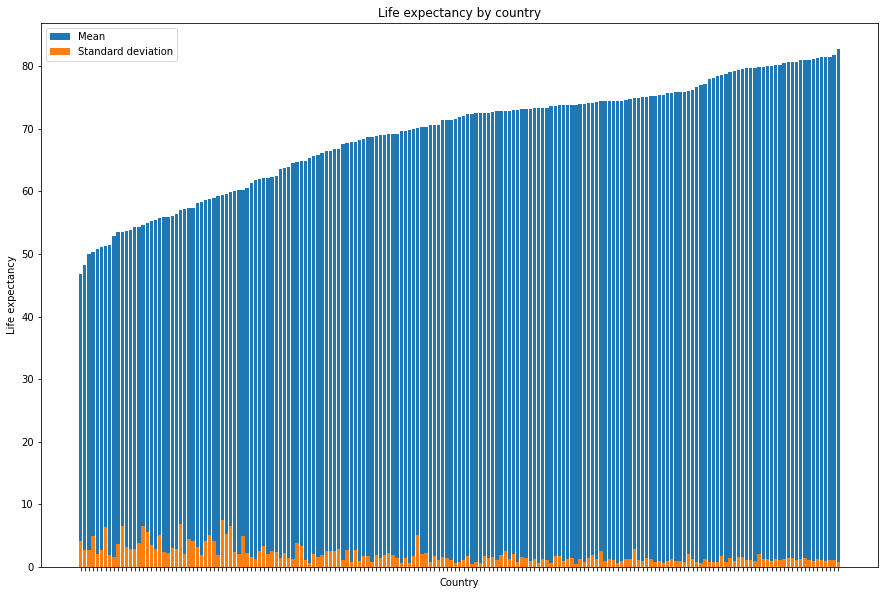

In [80]:
# Labels the x and y axes and sets the size of the plot
plt.figure(figsize=(15, 10))
plt.title('Life expectancy by country')
plt.xlabel('Country')
plt.ylabel('Life expectancy')

# Creates a dataset that computes the mean and standard deviation of the life expectancy for each country
# and merges the two values into one table
life_exp_mean = df.groupby('country', as_index=False)['life_expectancy'].mean()
life_exp_std = df.groupby('country', as_index=False)['life_expectancy'].std()
life_exp = life_exp_mean.merge(life_exp_std, how="outer", left_on = ["country"],  right_on = ["country"])

# Renames columns to have more recognizable names
life_exp = life_exp.rename(columns={"life_expectancy_x": "mean", "life_expectancy_y": "stdev"})

# Sorts based on mean
life_exp.sort_values('mean', inplace=True)

# Plots the bar graph shown below
plt.bar(x=life_exp['country'], height=life_exp['mean'], tick_label='')
plt.bar(x=life_exp['country'], height=life_exp['stdev'], tick_label='')

# Creates the legend that shows mean and standard deviation by color
plt.legend(['Mean', 'Standard deviation'], loc='upper left')

plt.show()

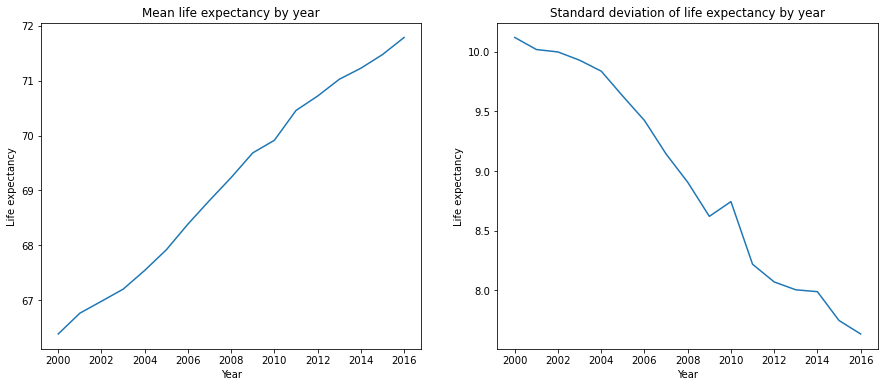

In [102]:
# Labels the x and y axes and sets the size of the plot
plt.figure(figsize=(15, 6))

# Subplot for mean graph
plt.subplot(1, 2, 1)

# Compute mean for each year and plot it
life_exp_mean = df.groupby('year', as_index=False)['life_expectancy'].mean()
plt.title('Mean life expectancy by year')
plt.xlabel('Year')
plt.ylabel('Life expectancy')
plt.plot(life_exp_mean['year'], life_exp_mean['life_expectancy'])

# Compute standard deviation for each year and plot it
plt.subplot(1, 2, 2)
life_exp_std = df.groupby('year', as_index=False)['life_expectancy'].std()
plt.title('Standard deviation of life expectancy by year')
plt.xlabel('Year')
plt.ylabel('Life expectancy')
plt.plot(life_exp_std['year'], life_exp_std['life_expectancy'])

plt.show()